In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import os.path as op
import glob
import matplotlib.pyplot as plt
import ast
# import moss
import csv
import random
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm

from statsmodels.stats.anova import AnovaRM
from sklearn.preprocessing import StandardScaler


In [2]:
# !pip install statsmodels

In [3]:
scaler = StandardScaler()

df = pd.read_csv('pilot5_TEST.csv')
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns


In [4]:
def remove_unit_variance(df, col, unit, group=None, suffix="_within"):
    """Remove variance between sampling units.

    This is useful for plotting repeated-measures data using within-unit
    error bars.

    Parameters
    ----------
    df : DataFrame
        Input data. Will have a new column added.
    col : column name
        Column in dataframe with quantitative measure to modify.
    unit : column name
        Column in dataframe defining sampling units (e.g., subjects).
    group : column name(s), optional
        Columns defining groups to remove unit variance within.
    suffix : string, optional
        Suffix appended to ``col`` name to create new column.

    Returns
    -------
    df : DataFrame
        Returns modified dataframe.

    """
    new_col = col + suffix

    def demean(x):
        return x - x.mean()

    if group is None:
        new = df.groupby(unit)[col].transform(demean)
        new += df[col].mean()
        df.loc[:, new_col] = new
    else:
        df.loc[:, new_col] = np.nan
        for level, df_level in df.groupby(group):
            new = df_level.groupby(unit)[col].transform(demean)
            new += df_level[col].mean()
            df.loc[new.index, new_col] = new

    return df

In [5]:
df = remove_unit_variance(df,'mouse.time_last','participant')
df['analysis_rt'] = df['mouse.time_last_within']

In [6]:
palette = sns.color_palette("husl", n_colors=2)[::-1]  # Reverse the color order


In [7]:
df['Distractor V2 Similarity Preference Tested']

0          Tested
1          Tested
2        Untested
3        Untested
4          Tested
           ...   
40495      Tested
40496    Untested
40497    Untested
40498    Untested
40499      Tested
Name: Distractor V2 Similarity Preference Tested, Length: 40500, dtype: object

In [8]:
df['Distractor V2 Similarity Preference'] = df['v2_prefers'] 
df['Distractor IT Similarity Preference'] = df['it_prefers']

column_params = {
    'v2': {'n_cats': 5, 'labels': ['Least Similar', '', ' ', '   ', 'Most Similar']},
    'it': {'n_cats': 5, 'labels': ['Least Similar', '', ' ', '   ', 'Most Similar']}
}

for label in ['it_sim_dis_attend', 'v2_sim_dis_attend', 'it_sim_dis_unattend', 'v2_sim_dis_unattend', 'it_sim_dis_diff', 'v2_sim_dis_diff', 'it_im1_im2', 'v2_im1_im2', 'it_sim_dis_test', 'v2_sim_dis_test', 'it_sim_dis_untest', 'v2_sim_dis_untest', 'it_sim_dis_diff_test', 'v2_sim_dis_diff_test', 'v2_sim_dis_diff_sq', 'it_sim_dis_diff_sq', 'v2_sim_dis_diff_test_sq','it_sim_dis_diff_test_sq']:
    
    if 'v2' in label:
        n_cats = column_params['v2']['n_cats']
        labels = column_params['v2']['labels']
    else:
        n_cats = column_params['it']['n_cats']
        labels = column_params['it']['labels']
    
    df[label + '_cat'] = pd.qcut(df[label], q=n_cats, labels=labels, duplicates='drop')


df['V2 Distractor Similarity\nto Prioritized Item'] = df['v2_sim_dis_attend_cat']
df['IT Distractor Similarity\nto Prioritized Item'] = df['it_sim_dis_attend_cat']
df['V2 Distractor Similarity\nto Deprioritized Item'] = df['v2_sim_dis_unattend_cat']
df['IT Distractor Similarity\nto Deprioritized Item'] = df['it_sim_dis_unattend_cat']
df['Prioritized - Deprioritized IT Distractor Similarity'] = df['it_sim_dis_diff_cat'] 
df['Prioritized - Deprioritized V2 Distractor Similarity'] = df['v2_sim_dis_diff_cat'] 
df['Prioritized - Deprioritized IT Distractor Similarity Squared'] = df['v2_sim_dis_diff_sq_cat'] 
df['Prioritized - Deprioritized V2 Distractor Similarity Squared'] = df['it_sim_dis_diff_sq_cat'] 


df['V2 Distractor Similarity\nto Tested Item'] = df['v2_sim_dis_test_cat']
df['IT Distractor Similarity\nto Tested Item'] = df['it_sim_dis_test_cat']
df['V2 Distractor Similarity\nto Untested Item'] = df['v2_sim_dis_untest_cat']
df['IT Distractor Similarity\nto Untested Item'] = df['it_sim_dis_untest_cat']
df['Tested - Untested IT Distractor Similarity'] = df['it_sim_dis_diff_test_cat'] 
df['Tested - Untested V2 Distractor Similarity'] = df['v2_sim_dis_diff_test_cat'] 
df['Tested - Untested IT Distractor Similarity Squared'] = df['v2_sim_dis_diff_test_sq_cat'] 
df['Tested - Untested V2 Distractor Similarity Squared'] = df['it_sim_dis_diff_test_sq_cat'] 


In [9]:
df['v2_sim_dis_untest']

0       -0.086920
1       -0.071200
2       -0.012499
3        0.022914
4       -0.081278
           ...   
40495   -0.022574
40496    0.049013
40497    0.086188
40498    0.053451
40499   -0.030105
Name: v2_sim_dis_untest, Length: 40500, dtype: float64

In [10]:
# df['it_sim_dis_diff'] = df['it_sim_dis_diff'] - np.mean(df['it_sim_dis_diff'])
# df['v2_sim_dis_diff'] = df['v2_sim_dis_diff'] - np.mean(df['v2_sim_dis_diff'])







# df['it_sim_dis_test'] = df['it_sim_dis_test'] - np.mean(df['it_sim_dis_test'])
# df['v2_sim_dis_test'] = df['v2_sim_dis_test'] - np.mean(df['v2_sim_dis_test'])

# df['it_sim_dis_diff_test'] = df['it_sim_dis_diff_test'] - np.mean(df['it_sim_dis_diff_test'])
# df['v2_sim_dis_diff_test'] = df['v2_sim_dis_diff_test'] - np.mean(df['v2_sim_dis_diff_test'])





# df['it_sim_dis_diff_sq'] = [x**2 for x in df['it_sim_dis_diff']]
# df['v2_sim_dis_diff_sq'] = [x**2 for x in df['v2_sim_dis_diff']]





# df['v2_sim_dis_test_sq'] = [x**2 for x in df['v2_sim_dis_test']]
# df['it_sim_dis_test_sq'] = [x**2 for x in df['it_sim_dis_test']]

# df['it_sim_dis_diff_test_sq'] = [x**2 for x in df['it_sim_dis_diff_test']]
# df['v2_sim_dis_diff_test_sq'] = [x**2 for x in df['v2_sim_dis_diff_test']]





# df['it_sim_dis_diff_sq'] = df['it_sim_dis_diff_sq'] - np.mean(df['it_sim_dis_diff_sq'])
# df['v2_sim_dis_diff_sq'] = df['v2_sim_dis_diff_sq'] - np.mean(df['v2_sim_dis_diff_sq'])



# df['v2_sim_dis_test_sq'] = df['v2_sim_dis_test_sq'] - np.mean(df['v2_sim_dis_test_sq'])
# df['it_sim_dis_test_sq'] = df['it_sim_dis_test_sq'] - np.mean(df['it_sim_dis_test_sq'])

# df['it_sim_dis_diff_test_sq'] = df['it_sim_dis_diff_test_sq'] - np.mean(df['it_sim_dis_diff_test_sq'])
# df['v2_sim_dis_diff_test_sq'] = df['v2_sim_dis_diff_test_sq'] - np.mean(df['v2_sim_dis_diff_test_sq'])




df['IT_diff_binned'] = pd.qcut(df['it_sim_dis_diff'], 5, duplicates='drop')
df['V2_diff_binned'] = pd.qcut(df['v2_sim_dis_diff'], 5, duplicates='drop')
df['IT_diff_binned_sq'] = pd.qcut(df['it_sim_dis_diff_sq'], 5, duplicates='drop')
df['V2_diff_binned_sq'] = pd.qcut(df['v2_sim_dis_diff_sq'], 5, duplicates='drop')




df['IT_diff_binned_test'] = pd.qcut(df['it_sim_dis_diff_test'], 5, duplicates='drop')
df['V2_diff_binned_test'] = pd.qcut(df['v2_sim_dis_diff_test'], 5, duplicates='drop')
df['IT_diff_binned_test_sq'] = pd.qcut(df['it_sim_dis_diff_test_sq'], 5, duplicates='drop')
df['V2_diff_binned_test_sq'] = pd.qcut(df['v2_sim_dis_diff_test_sq'], 5, duplicates='drop')

def round_to_significant_figures(x, sig_figs=2):
    if x == 0:
        return 0
    else:
        return round(x, sig_figs - int(np.floor(np.log10(abs(x)))) - 1)


def process_interval(interval):
    # Round both bounds
    lower_rounded = round_to_significant_figures(interval.left)
    upper_rounded = round_to_significant_figures(interval.right)
    # Return a new interval with the rounded bounds
    return pd.Interval(lower_rounded, upper_rounded)

df['IT_diff_binned'] = df['IT_diff_binned'].apply(process_interval)
df['V2_diff_binned'] = df['V2_diff_binned'].apply(process_interval)
df['IT_diff_binned_sq'] = df['IT_diff_binned_sq'].apply(process_interval)
df['V2_diff_binned_sq'] = df['V2_diff_binned_sq'].apply(process_interval)

df['IT_diff_binned_test'] = df['IT_diff_binned_test'].apply(process_interval)
df['V2_diff_binned_test'] = df['V2_diff_binned_test'].apply(process_interval)
df['IT_diff_binned_test_sq'] = df['IT_diff_binned_test_sq'].apply(process_interval)
df['V2_diff_binned_test_sq'] = df['V2_diff_binned_test_sq'].apply(process_interval)

df['Prioritized - Deprioritized V2 Distractor Similarity Ranges'] = df['V2_diff_binned']
df['Prioritized - Deprioritized IT Distractor Similarity Ranges'] = df['IT_diff_binned']
df['Prioritized - Deprioritized V2 Distractor Similarity Squared Ranges'] = df['V2_diff_binned_sq']
df['Prioritized - Deprioritized IT Distractor Similarity Squared Ranges'] = df['IT_diff_binned_sq']

df['Tested - Untested V2 Distractor Similarity Ranges'] = df['V2_diff_binned_test']
df['Tested - Untested IT Distractor Similarity Ranges'] = df['IT_diff_binned_test']
df['Tested - Untested V2 Distractor Similarity Squared Ranges'] = df['V2_diff_binned_test_sq']
df['Tested - Untested IT Distractor Similarity Squared Ranges'] = df['IT_diff_binned_test_sq']





In [11]:
# df['tested_item'] = df['Tested Item']
# df['ret_rel'] = df['Retrocue Reliability']

In [12]:
len(set(df['participant']))

134

In [13]:
df_correct = df[df['resp_correct'] == 1]


In [14]:
df

,setup_js.started,setup_js.stopped,participant,date,expName,psychopyVersion,OS,frameRate,Instructions1.started,Instructions1.stopped,...,tested_memorability,untested_memorability,attended_memorability,unattended_memorability,tested_memorability_resmem,untested_memorability_resmem,attended_memorability_resmem,unattended_memorability_resmem,distractor_memorability,pilot_number
0,NaN,NaN,116851,2024-10-12 15:22:21.820,WM_Deepgen,2024.1.5,Win32,59.52381,NaN,NaN,...,0.828125,0.394366,0.828125,0.394366,0.821004,0.957775,0.821004,0.957775,0.693520,1
1,NaN,NaN,116851,2024-10-12 15:22:21.820,WM_Deepgen,2024.1.5,Win32,59.52381,NaN,NaN,...,0.779221,0.913793,0.779221,0.913793,0.890449,0.852276,0.890449,0.852276,0.788328,1
2,NaN,NaN,116851,2024-10-12 15:22:21.820,WM_Deepgen,2024.1.5,Win32,59.52381,NaN,NaN,...,0.865854,0.735849,0.735849,0.865854,0.972881,0.797583,0.797583,0.972881,0.923806,1
3,NaN,NaN,116851,2024-10-12 15:22:21.820,WM_Deepgen,2024.1.5,Win32,59.52381,NaN,NaN,...,0.776316,0.593220,0.776316,0.593220,0.846955,0.943598,0.846955,0.943598,0.764632,1
4,NaN,NaN,116851,2024-10-12 15:22:21.820,WM_Deepgen,2024.1.5,Win32,59.52381,NaN,NaN,...,0.847059,0.700000,0.700000,0.847059,0.817970,0.632215,0.632215,0.817970,0.789508,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40495,NaN,NaN,167080,2024-10-28 17:42:43.597,WM_Deepgen,2023.2.1,MacIntel,62.50000,NaN,NaN,...,0.846154,0.628571,0.846154,0.628571,0.929148,0.658279,0.929148,0.658279,0.860407,1
40496,NaN,NaN,167080,2024-10-28 17:42:43.597,WM_Deepgen,2023.2.1,MacIntel,62.50000,NaN,NaN,...,0.776316,0.745763,0.745763,0.776316,0.900686,0.929223,0.929223,0.900686,0.854751,1
40497,NaN,NaN,167080,2024-10-28 17:42:43.597,WM_Deepgen,2023.2.1,MacIntel,62.50000,NaN,NaN,...,0.622951,0.810811,0.622951,0.810811,0.832947,0.912276,0.832947,0.912276,0.860736,1
40498,NaN,NaN,167080,2024-10-28 17:42:43.597,WM_Deepgen,2023.2.1,MacIntel,62.50000,NaN,NaN,...,0.911392,0.839286,0.839286,0.911392,0.793200,0.731162,0.731162,0.793200,0.843144,1


<Figure size 1000x600 with 0 Axes>

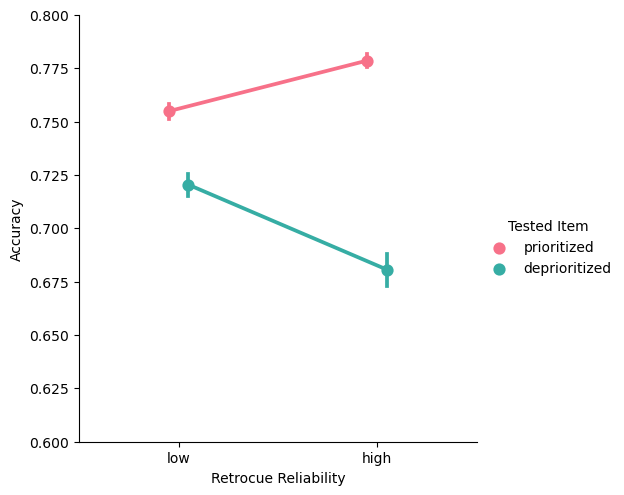

In [15]:

plt.figure(figsize=(10, 6))
sns.catplot(
    x='Retrocue Reliability',
    y='Accuracy',
    errorbar=('ci', 68),  # Updated error bar parameter
    order = ['low','high'],
#     col = 'participant',
    kind = 'point',
    hue='Tested Item',
    dodge=0.1,
    palette=palette[::-1],  # Use the single-color palette
    data=df
)
plt.ylim(0.6, 0.8)
plt.ylabel('Accuracy')
# plt.xlabel('V2 Distractor Similarity to Prioritized Item')
# plt.title('Accuracy by V2 Distractor Similarity')
plt.show()



# plt.figure(figsize=(10, 6))
# sns.lmplot(
#     x='Retrocue Reliability',
#     y='Accuracy',
# #    x_bins = 5,
# #     order = 2,
#     ci = 68,
# #     hue = 'it_prefers_test',
# #     x_ci = 68,
#     data=df
# )


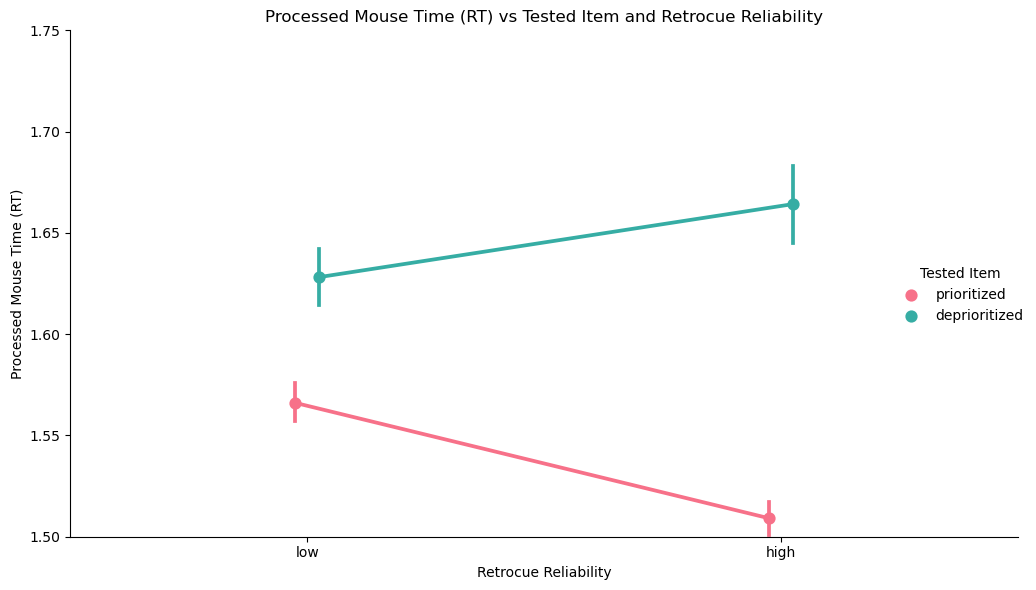

In [16]:
g = sns.catplot(x='Retrocue Reliability', y='analysis_rt', hue='Tested Item', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            order=['low', 'high'],  # Specify the order of the categories
            palette = palette[::-1])
g.set(ylim=(1.5, 1.75))

plt.xlabel('Retrocue Reliability')
plt.ylabel('Processed Mouse Time (RT)')
plt.title('Processed Mouse Time (RT) vs Tested Item and Retrocue Reliability')
plt.tight_layout()
plt.show()

In [17]:
df['V2 Distractor Similarity\nto Tested Item']

0                     
1                     
2        Least Similar
3                     
4         Most Similar
             ...      
40495                 
40496                 
40497                 
40498    Least Similar
40499                 
Name: V2 Distractor Similarity\nto Tested Item, Length: 40500, dtype: category
Categories (5, object): ['Least Similar' < '' < ' ' < '   ' < 'Most Similar']

In [18]:
# df['v2_sim_dis_test_sq_z']

In [19]:
# df['V2 Distractor Similarity to Tested Item'] = df['v2_sim_dis_test_z']
# df['IT Distractor Similarity to Tested Item'] = df['it_sim_dis_test_z']
# df['Tested - Untested V2 Distractor Similarity'] = df['v2_sim_dis_diff_test_z']
# df['Tested - Untested IT Distractor Similarity'] = df['it_sim_dis_diff_test_z']


# df['it_sim_dis_attend_sq_z'] = scaler.fit_transform(df[['it_sim_dis_attend_sq']])
# df['it_sim_dis_unattend_sq_z'] = scaler.fit_transform(df[['it_sim_dis_unattend_sq']])
# df['v2_sim_dis_attend_sq_z'] = scaler.fit_transform(df[['v2_sim_dis_attend_sq']])
# df['v2_sim_dis_unattend_sq_z'] = scaler.fit_transform(df[['v2_sim_dis_unattend_sq']])


In [20]:
# df['V2 Distractor Similarity\nto Prioritized Item'] = df['v2_sim_dis_attend_z']
# df['IT Distractor Similarity\nto Prioritized Item'] = df['it_sim_dis_attend_z']
# df['V2 Distractor Similarity\nto Deprioritized Item'] = df['v2_sim_dis_unattend_z']
# df['IT Distractor Similarity\nto Deprioritized Item'] = df['it_sim_dis_unattend_z']

# df['Prioritized - Deprioritized IT Distractor Similarity'] = df['it_sim_dis_diff_z'] 
# df['Prioritized - Deprioritized V2 Distractor Similarity'] = df['v2_sim_dis_diff_z'] 

In [21]:
# df['it_sim_dis_test_sq_z']

In [22]:
# df['it_sim_dis_attend_sq_z'] = scaler.fit_transform(df[['it_sim_dis_attend_sq']])
# df['it_sim_dis_unattend_sq_z'] = scaler.fit_transform(df[['it_sim_dis_unattend_sq']])
# df['v2_sim_dis_attend_sq_z'] = scaler.fit_transform(df[['v2_sim_dis_attend_sq']])
# df['v2_sim_dis_unattend_sq_z'] = scaler.fit_transform(df[['v2_sim_dis_unattend_sq']])


# df['it_sim_dis_test_z'] = scaler.fit_transform(df[['it_sim_dis_test']])
# df['v2_sim_dis_test_z'] = scaler.fit_transform(df[['v2_sim_dis_test']])

# df['v2_sim_dis_test_sq_z'] = scaler.fit_transform(df[['v2_sim_dis_test_sq']])
# df['it_sim_dis_test_sq_z'] = scaler.fit_transform(df[['it_sim_dis_test_sq']])

# df['validity_binary'] = df['Tested Item'].apply(lambda x: 1 if x == 'prioritized' else 0)
# df['reliability_binary'] = df['Retrocue Reliability'].apply(lambda x: 1 if x == 'high' else 0)

# df['validity_binary_z'] = scaler.fit_transform(df[['validity_binary']])
# df['reliability_binary_z'] = scaler.fit_transform(df[['reliability_binary']])

# df.to_csv('pilot5_TEST.csv', index=False)  # Set index=False to avoid saving row indices


In [23]:
df['IT_root_im1']

0       -0.072110
1       -0.196799
2       -0.105560
3       -0.166122
4       -0.203215
           ...   
40495   -0.278895
40496    0.624863
40497   -0.292477
40498    0.020340
40499   -0.039632
Name: IT_root_im1, Length: 40500, dtype: float64

In [24]:
filtered_values = df[df['V2 Distractor Similarity to Tested Item'] > 0.10]
print(len(filtered_values))

16615


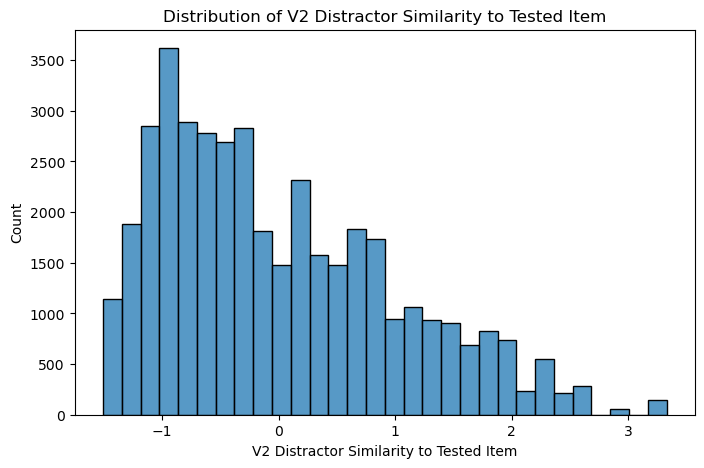

In [25]:
plt.figure(figsize=(8, 5))
sns.histplot(df['V2 Distractor Similarity to Tested Item'], bins=30)
plt.title('Distribution of V2 Distractor Similarity to Tested Item')
plt.show()


<Figure size 1000x600 with 0 Axes>

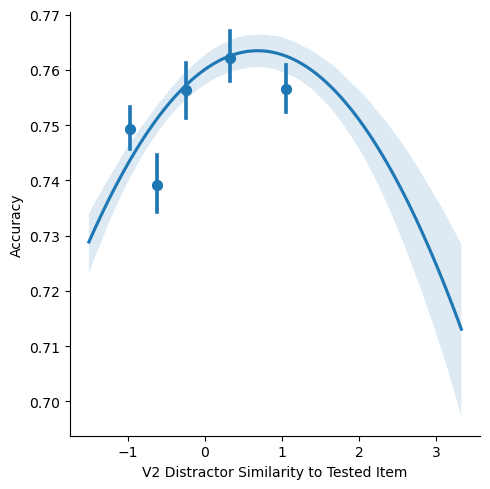

In [26]:
single_color = palette[0]  # Use the first color from the palette
single_color_palette = [single_color]

# plt.figure(figsize=(10, 6))
# sns.pointplot(
#     x='V2 Distractor Similarity\nto Tested Item',
#     y='Accuracy',
#     errorbar=('ci', 68),  # Updated error bar parameter
#     dodge=0.5,
#     palette=single_color_palette,  # Use the single-color palette
#     data=df
# )
# plt.ylim(0.7, 0.85)
# plt.ylabel('Accuracy')
# plt.xlabel('V2 Distractor Similarity to Tested Item')
# plt.title('Accuracy by V2 Distractor Similarity')
# plt.show()




plt.figure(figsize=(10, 6))
sns.lmplot(
    x='V2 Distractor Similarity to Tested Item',
    y='Accuracy',
    x_bins = 5,
    order = 2,
    ci = 68,
    data=df
)

<Figure size 1000x600 with 0 Axes>

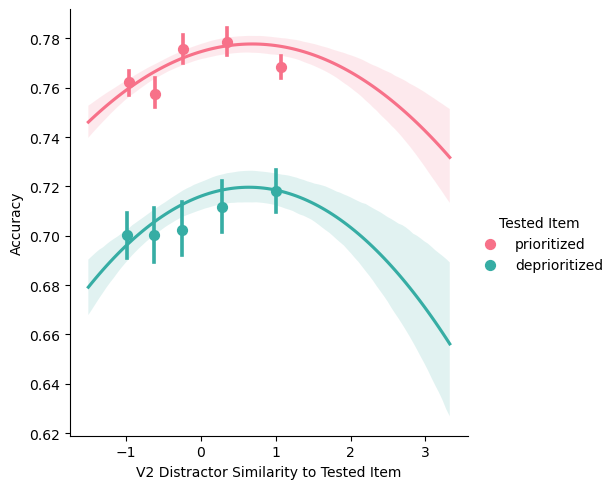

In [27]:
# g = sns.catplot(
#             x = 'V2 Distractor Similarity\nto Tested Item',
#             y = 'Accuracy',
#             ci = 68,
#             hue = 'Tested Item',
#             # col = 'Retrocue Reliability',
#             aspect = 1.3,
#             dodge = 0.5,
#             kind = 'point',
#             palette = palette[::-1],  # Reverse the color order
#             data = df)
# g.set(ylim=(0.55, 0.85))
# plt.ylabel('Accuracy')



plt.figure(figsize=(10, 6))
sns.lmplot(
    x='V2 Distractor Similarity to Tested Item',
    y='Accuracy',
    hue = 'Tested Item',
    x_bins = 5,
    order = 2,
    ci = 68,
    palette = palette[::-1],  # Reverse the color order

    data=df
)

<Figure size 1000x600 with 0 Axes>

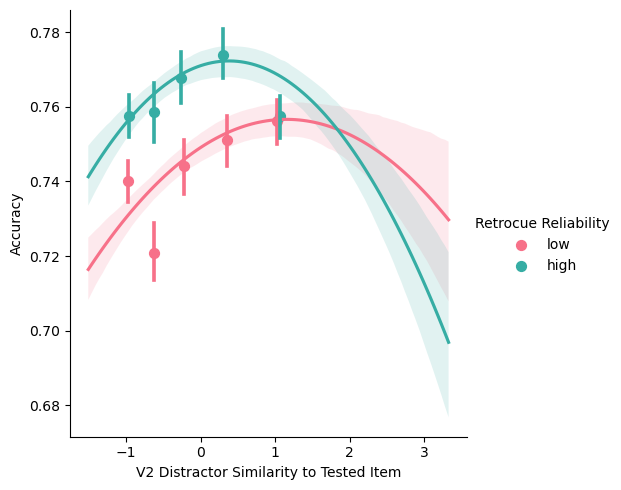

In [28]:
plt.figure(figsize=(10, 6))
sns.lmplot(
    x='V2 Distractor Similarity to Tested Item',
    y='Accuracy',
    hue = 'Retrocue Reliability',
    x_bins = 5,
    order = 2,
    ci = 68,
    palette = palette[::-1],  # Reverse the color order

    data=df
)


<Figure size 1000x600 with 0 Axes>

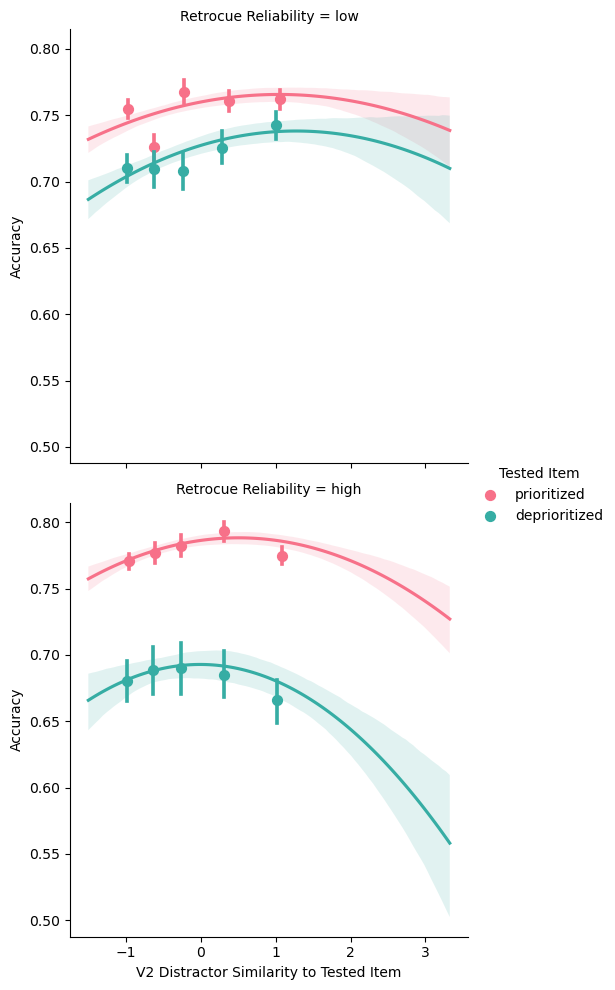

In [29]:
# g = sns.catplot(
#     x='V2 Distractor Similarity\nto Tested Item',
#     y='Accuracy',
#     ci=68,
#     hue='Tested Item',
#     row='Retrocue Reliability',  # Use 'row' instead of 'col' to arrange plots vertically
#     aspect=1.3,
#     dodge=0.5,
#     kind='point',
#     row_order = ['low', 'high'],
#     palette=palette[::-1],  # Reverse the color order
#     data=df
# )
# g.set(ylim=(0.50, 0.85))
# g.set_axis_labels("", "Accuracy")

# plt.show()


plt.figure(figsize=(10, 6))
sns.lmplot(
    x='V2 Distractor Similarity to Tested Item',
    y='Accuracy',
    hue='Tested Item',
    row = 'Retrocue Reliability',
    x_bins = 5,
    order = 2,
    ci = 68,
    palette = palette[::-1],  # Reverse the color order

    data=df
)


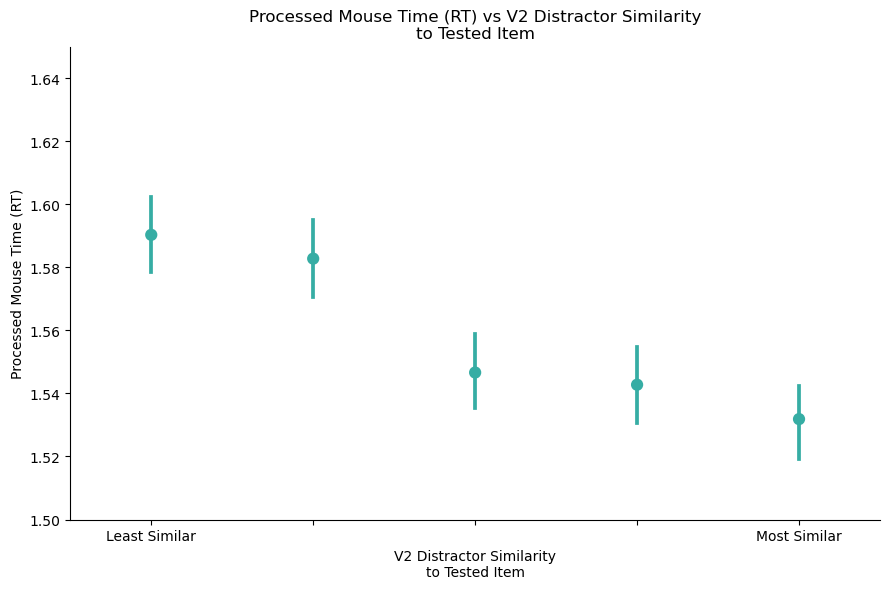

In [30]:
g = sns.catplot(x='V2 Distractor Similarity\nto Tested Item', y='analysis_rt', 
#                 hue='Tested Item', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            # order=['Least Similar', ' ', ' ', ' ', 'Most Similar'],  # Specify the order of the categories
            palette = single_color_palette  # Reverse the color order
)
g.set(ylim=(1.5, 1.65))

plt.xlabel('V2 Distractor Similarity\nto Tested Item')
plt.ylabel('Processed Mouse Time (RT)')
plt.title('Processed Mouse Time (RT) vs V2 Distractor Similarity\nto Tested Item')
plt.tight_layout()
plt.show()

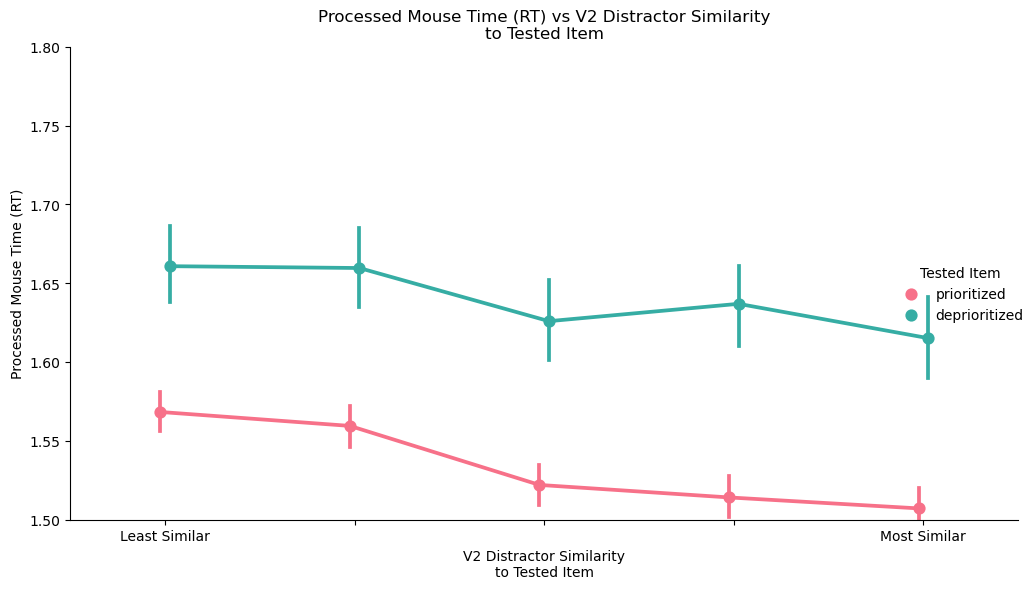

In [31]:
g = sns.catplot(x='V2 Distractor Similarity\nto Tested Item', y='analysis_rt', 
                hue='Tested Item', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            palette = palette[::-1]  # Reverse the color order
)
g.set(ylim=(1.5, 1.8))

plt.xlabel('V2 Distractor Similarity\nto Tested Item')
plt.ylabel('Processed Mouse Time (RT)')
plt.title('Processed Mouse Time (RT) vs V2 Distractor Similarity\nto Tested Item')
plt.tight_layout()
plt.show()

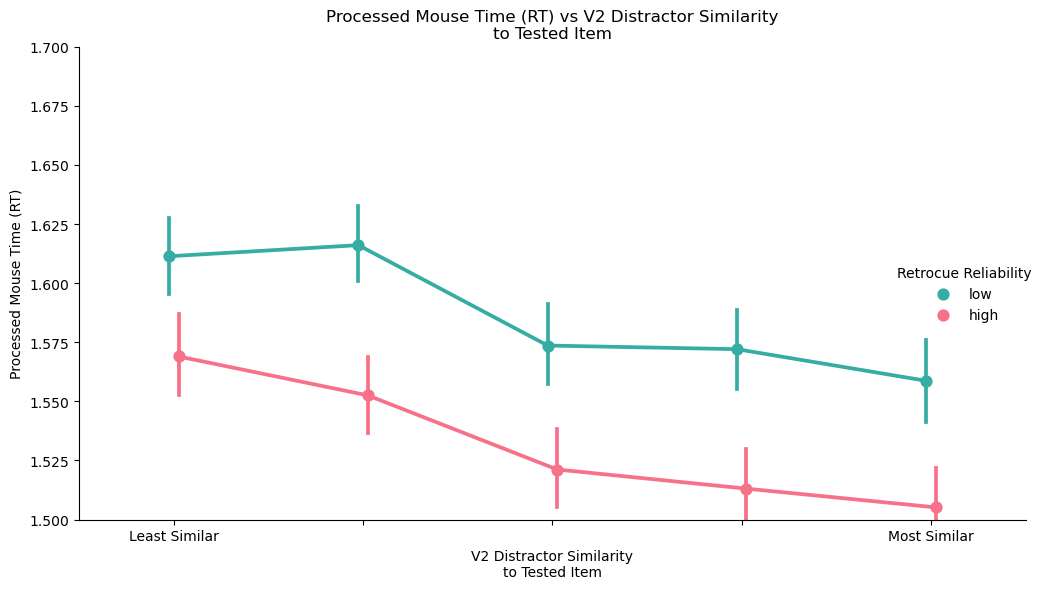

In [32]:
g = sns.catplot(x='V2 Distractor Similarity\nto Tested Item', y='analysis_rt', 
                hue='Retrocue Reliability', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            palette = palette  # Reverse the color order
)
g.set(ylim=(1.5, 1.7))

plt.xlabel('V2 Distractor Similarity\nto Tested Item')
plt.ylabel('Processed Mouse Time (RT)')
plt.title('Processed Mouse Time (RT) vs V2 Distractor Similarity\nto Tested Item')
plt.tight_layout()
plt.show()

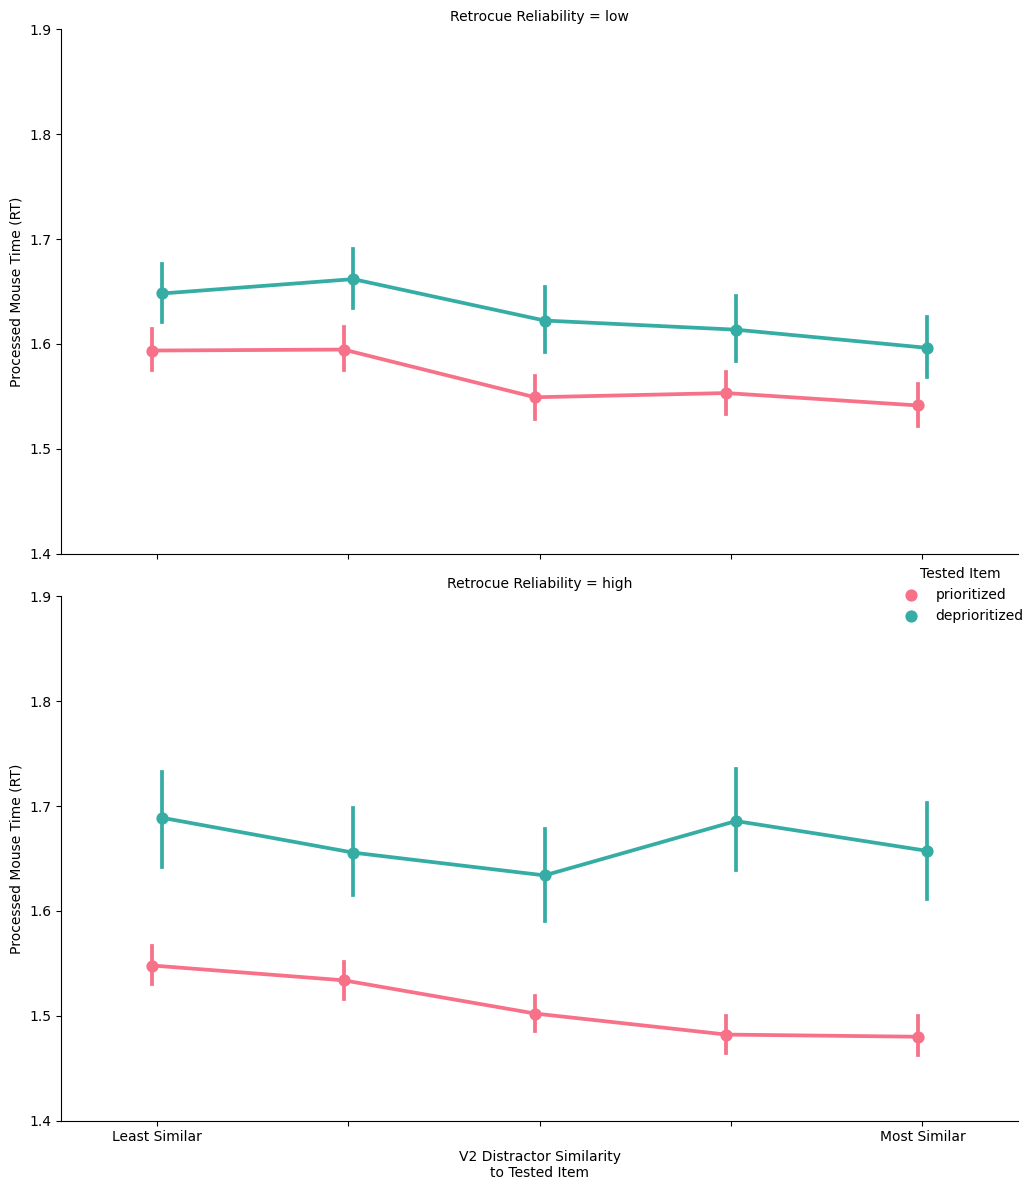

In [33]:
g = sns.catplot(x='V2 Distractor Similarity\nto Tested Item', y='analysis_rt', 
                hue='Tested Item', row='Retrocue Reliability',  # Use 'row' instead of 'col'
                kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
                palette=palette[::-1]  # Reverse the color order
)
g.set(ylim=(1.4, 1.9))

g.set_axis_labels('V2 Distractor Similarity\nto Tested Item', 'Processed Mouse Time (RT)')
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

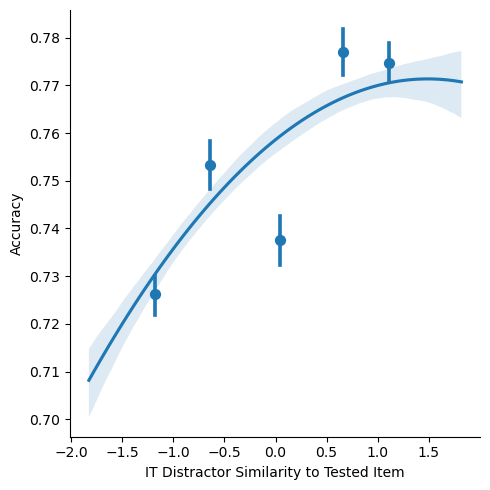

In [34]:


# plt.figure(figsize=(10, 6))
# sns.pointplot(
#     x='IT Distractor Similarity\nto Tested Item',
#     y='Accuracy',
#     errorbar=('ci', 68),  # Updated error bar parameter
#     dodge=0.5,
#     palette=single_color_palette,  # Use the single-color palette
#     data=df
# )
# plt.ylim(0.7, 0.85)
# plt.ylabel('Accuracy')
# plt.xlabel('IT Distractor Similarity to Tested Item')
# plt.title('Accuracy by IT Distractor Similarity')
# plt.show()


plt.figure(figsize=(10, 6))
sns.lmplot(
    x='IT Distractor Similarity to Tested Item',
    y='Accuracy',
    x_bins = 5,
    order = 2,
    ci = 68,
    palette = palette[::-1],  # Reverse the color order
    data=df
)



In [35]:

# plt.figure(figsize=(10, 6))
# sns.pointplot(
#     x='IT Distractor Similarity\nto Prioritized Item',
#     y='Tested Item',
#     errorbar=('ci', 68),  # Updated error bar parameter
#     dodge=0.5,
#     palette=single_color_palette,  # Use the single-color palette
#     data=df
# )
# plt.ylim(0.7, 0.85)
# plt.ylabel('Accuracy')
# plt.xlabel('IT Distractor Similarity to Prioritized Item')
# plt.title('Accuracy by IT Distractor Similarity')
# plt.show()



# g = sns.catplot(
#     x='V2 Distractor Similarity\nto Tested Item',
#     y='reliability_binary',
#     ci=68,
# #     hue='Tested Item',
# #     row='Retrocue Reliability',  # Use 'row' instead of 'col' to arrange plots vertically
#     aspect=1.3,
#     dodge=0.5,
#     kind='point',
#     row_order = ['low', 'high'],
# #     palette=palette,  # Reverse the color order
#     data=df)


# plt.show()

<Figure size 1000x600 with 0 Axes>

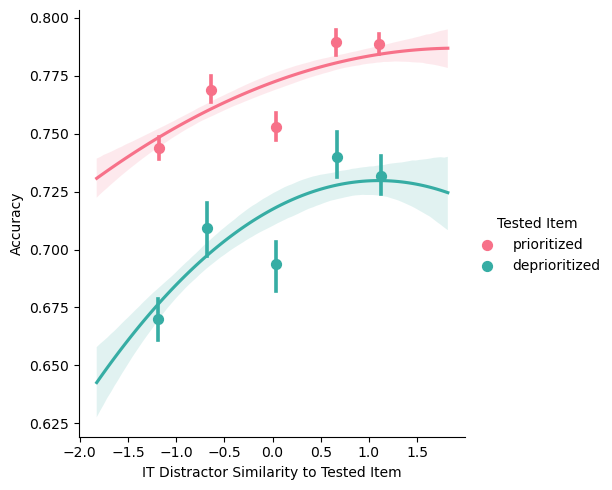

In [36]:
plt.figure(figsize=(10, 6))
sns.lmplot(
    x='IT Distractor Similarity to Tested Item',
    y='Accuracy',
    hue = 'Tested Item',
    x_bins = 5,
    order = 2,
    ci = 68,
    palette = palette[::-1],  # Reverse the color order
    data=df
)


In [37]:
# g = sns.catplot(
#             x = 'IT Distractor Similarity\nto Tested Item',
#             y = 'Accuracy',
#             ci = 68,
#             hue = 'Tested Item',
#             # col = 'Retrocue Reliability',
#             aspect = 1.3,
#             dodge = 0.5,
#             kind = 'point',
#             palette = palette[::-1],  # Reverse the color order
#             data = df)
# g.set(ylim=(0.55, 0.85))
# plt.ylabel('Accuracy')

<Figure size 1000x600 with 0 Axes>

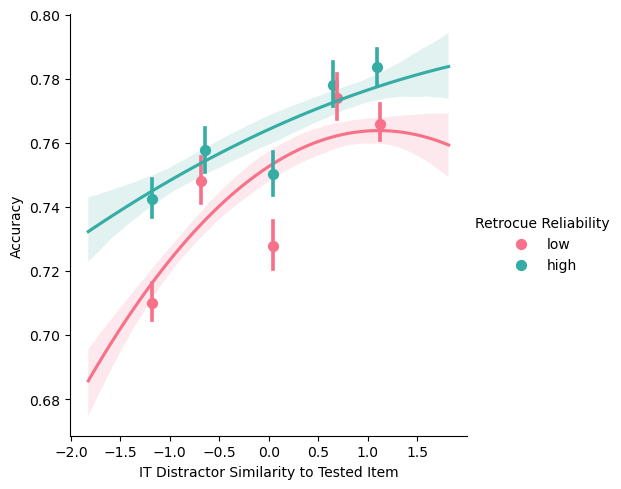

In [38]:
# g = sns.catplot(
#             x = 'IT Distractor Similarity\nto Tested Item',
#             y = 'Accuracy',
#             ci = 68,
#             hue = 'Retrocue Reliability',
#             # col = 'Retrocue Reliability',
#             aspect = 1.3,
#             dodge = 0.5,
#             kind = 'point',
#             palette = palette,  # Reverse the color order
#             data = df)
# g.set(ylim=(0.55, 0.85))
# plt.ylabel('Accuracy')


plt.figure(figsize=(10, 6))
sns.lmplot(
    x='IT Distractor Similarity to Tested Item',
    y='Accuracy',
    hue = 'Retrocue Reliability',
    x_bins = 5,
    order = 2,
    ci = 68,
    palette = palette[::-1],  # Reverse the color order
    data=df
)


<Figure size 1000x600 with 0 Axes>

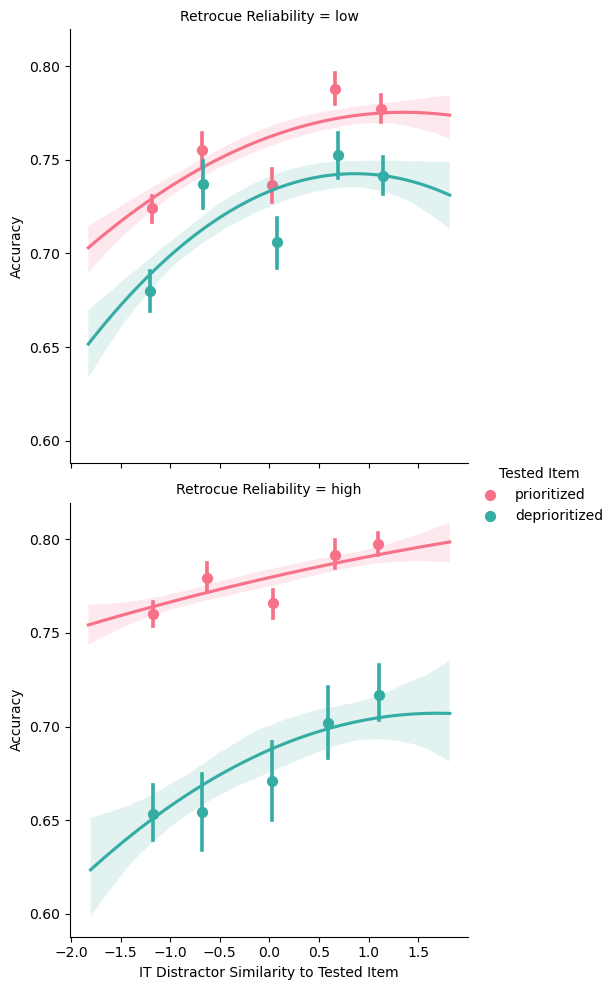

In [39]:
# g = sns.catplot(
#     x='IT Distractor Similarity\nto Tested Item',
#     y='Accuracy',
#     ci=68,
#     hue='Tested Item',
    
#     row='Retrocue Reliability',  # Use 'row' instead of 'col' to arrange plots vertically
#     aspect=1.3,
#     row_order = ['low', 'high'],
#     dodge=0.5,
#     kind='point',
#     palette=palette[::-1],  # Reverse the color order
#     data=df
# )
# g.set(ylim=(0.5, 0.85))
# g.set_axis_labels("", "Accuracy")

# plt.show()


plt.figure(figsize=(10, 6))
sns.lmplot(
    x='IT Distractor Similarity to Tested Item',
    y='Accuracy',
    hue='Tested Item',
    row='Retrocue Reliability',  
    x_bins = 5,
    order = 2,
    ci = 68,
    palette = palette[::-1],  # Reverse the color order
    data=df
)


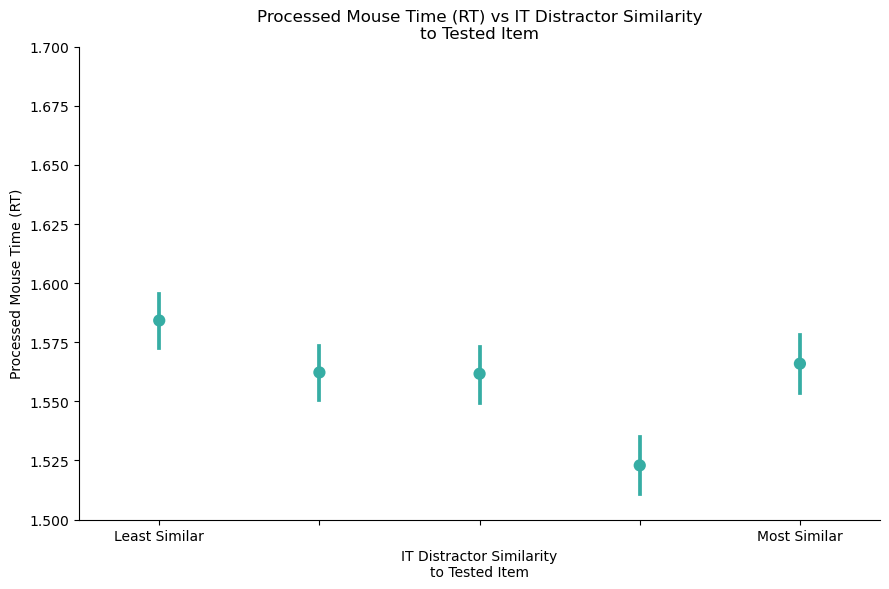

In [40]:
g = sns.catplot(x='IT Distractor Similarity\nto Tested Item', y='analysis_rt', 
#                 hue='Tested Item', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            # order=['Least Similar', ' ', ' ', ' ', 'Most Similar'],  # Specify the order of the categories
            palette = single_color_palette  # Reverse the color order
)
g.set(ylim=(1.5, 1.7))

plt.xlabel('IT Distractor Similarity\nto Tested Item')
plt.ylabel('Processed Mouse Time (RT)')
plt.title('Processed Mouse Time (RT) vs IT Distractor Similarity\nto Tested Item')
plt.tight_layout()
plt.show()

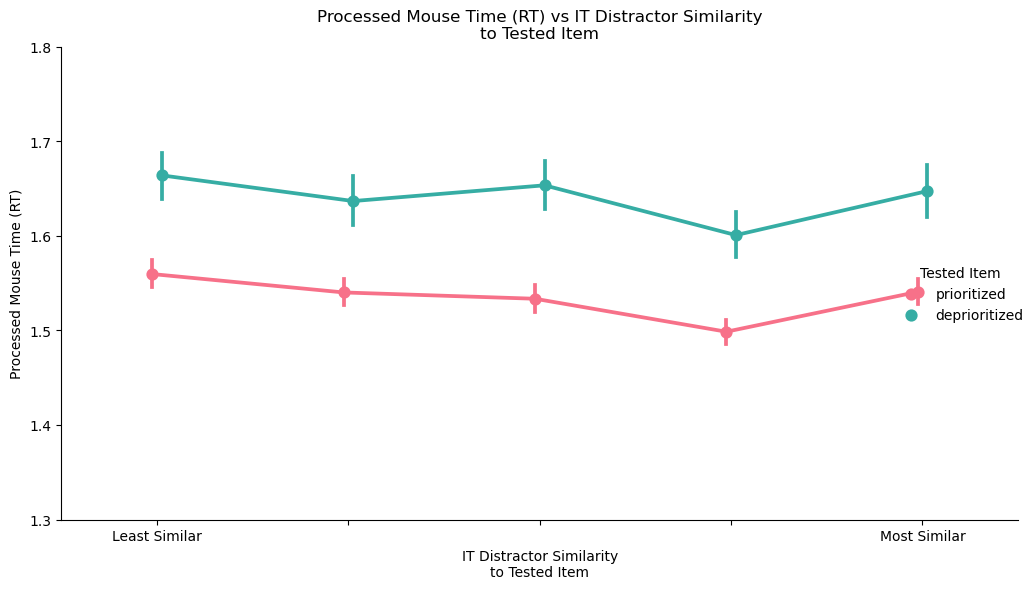

In [41]:
g = sns.catplot(x='IT Distractor Similarity\nto Tested Item', y='analysis_rt', 
                hue='Tested Item', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            palette = palette[::-1]  # Reverse the color order
)
g.set(ylim=(1.3, 1.8))

plt.xlabel('IT Distractor Similarity\nto Tested Item')
plt.ylabel('Processed Mouse Time (RT)')
plt.title('Processed Mouse Time (RT) vs IT Distractor Similarity\nto Tested Item')
plt.tight_layout()
plt.show()

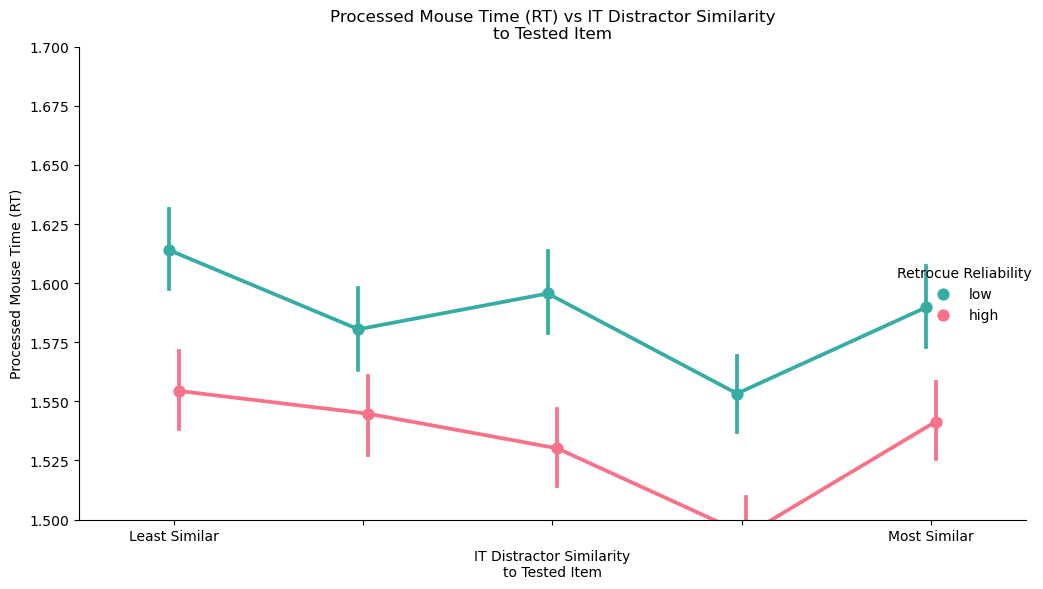

In [42]:
g = sns.catplot(x='IT Distractor Similarity\nto Tested Item', y='analysis_rt', 
                hue='Retrocue Reliability', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            palette = palette  # Reverse the color order
)
g.set(ylim=(1.5, 1.7))

plt.xlabel('IT Distractor Similarity\nto Tested Item')
plt.ylabel('Processed Mouse Time (RT)')
plt.title('Processed Mouse Time (RT) vs IT Distractor Similarity\nto Tested Item')
plt.tight_layout()
plt.show()

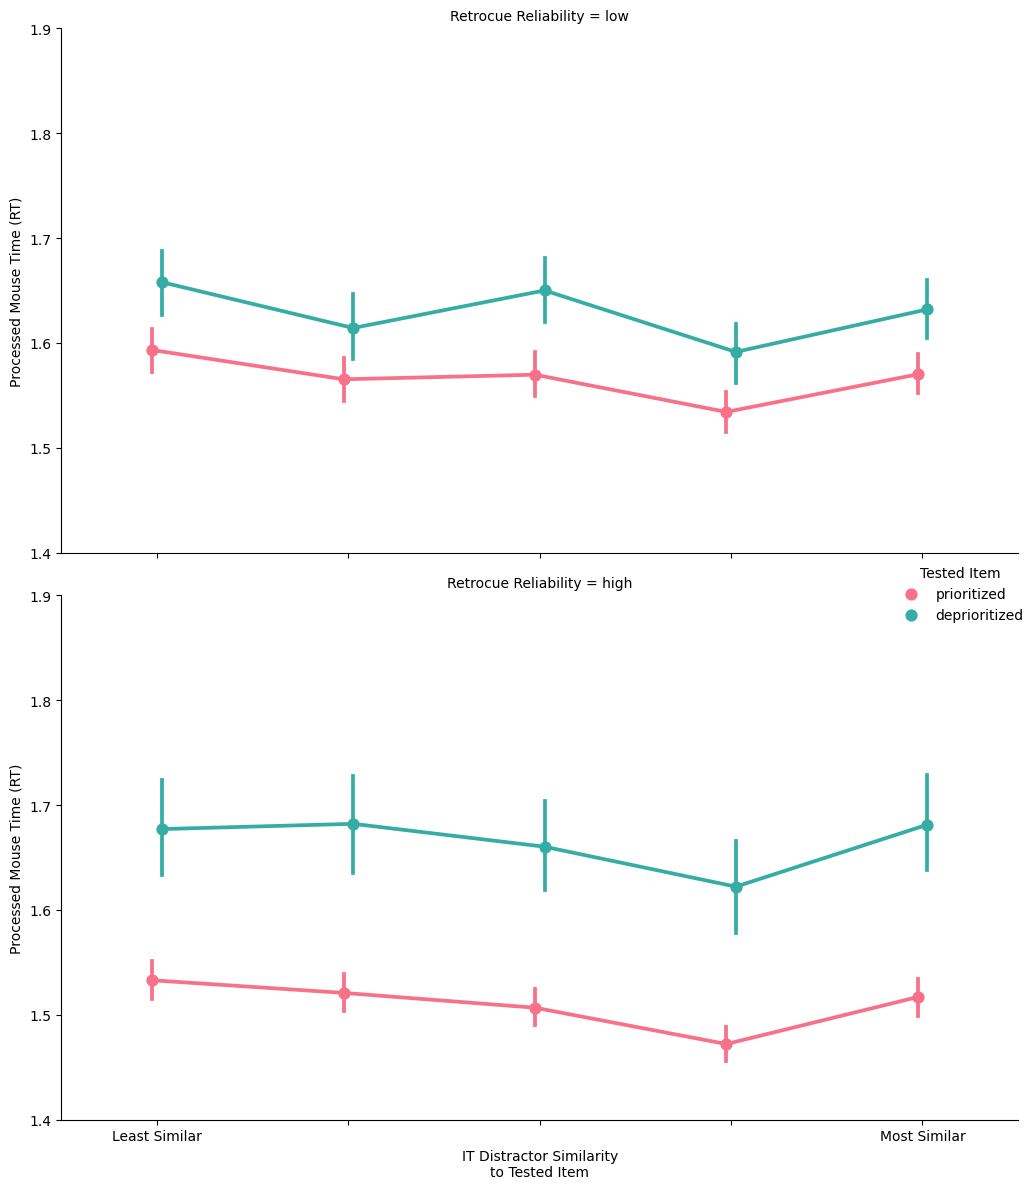

In [43]:
g = sns.catplot(x='IT Distractor Similarity\nto Tested Item', y='analysis_rt', 
                hue='Tested Item', row='Retrocue Reliability',  # Use 'row' instead of 'col'
                kind='point',row_order = ['low', 'high'], data=df_correct, dodge=True, height=6, aspect=1.5, 
                palette=palette[::-1]  # Reverse the color order
)
g.set(ylim=(1.4, 1.9))

g.set_axis_labels('IT Distractor Similarity\nto Tested Item', 'Processed Mouse Time (RT)')
plt.tight_layout()
plt.show()

In [44]:
# df['IT_diff_binned'] = pd.qcut(df['it_sim_dis_diff'], 5, duplicates='drop')
# df['V2_diff_binned'] = pd.qcut(df['v2_sim_dis_diff'], 5, duplicates='drop')

# def round_to_significant_figures(x, sig_figs=2):
#     if x == 0:
#         return 0
#     else:
#         return round(x, sig_figs - int(np.floor(np.log10(abs(x)))) - 1)


# def process_interval(interval):
#     # Round both bounds
#     lower_rounded = round_to_significant_figures(interval.left)
#     upper_rounded = round_to_significant_figures(interval.right)
#     # Return a new interval with the rounded bounds
#     return pd.Interval(lower_rounded, upper_rounded)

# df['IT_diff_binned'] = df['IT_diff_binned'].apply(process_interval)
# df['V2_diff_binned'] = df['V2_diff_binned'].apply(process_interval)

# df['Prioritized - Deprioritized V2 Distractor Similarity Ranges'] = df['V2_diff_binned']
# df['Prioritized - Deprioritized IT Distractor Similarity Ranges'] = df['IT_diff_binned']

In [45]:
# plt.figure(figsize=(10, 6))
# ax = sns.pointplot(
#     x='V2_diff_binned_test',
#     y='Accuracy',
# #     errorbar=('ci', 68),  # Updated error bar parameter
#     data=df
# )
# # sns.regplot(
# #     x='v2_sim_dis_diff',
# #     y='Accuracy',
# #     order = 2,
# #     ci = 68,
# #     errorbar=('ci', 68),  # Updated error bar parameter
# #     scatter = False,
# #     data=df,
# #     ax = ax,
# # )
# plt.ylim(0.7, 0.8)
# plt.ylabel('Accuracy')
# plt.xlabel('Tested - Untested V2 Distractor Similarity')
# plt.title('Accuracy by V2 Distractor Similarity')
# plt.show()

In [46]:
# plt.figure(figsize=(10, 6))
# sns.relplot(
#     x='v2_sim_dis_diff_test',
#     y='Accuracy',
#     kind = 'line',
# #     errorbar=('ci', 68),  # Updated error bar parameter
#     palette=single_color_palette,  # Use the single-color palette
#     data=df
# )

ValueError: could not convert string to float: ' '

<Figure size 1000x600 with 0 Axes>

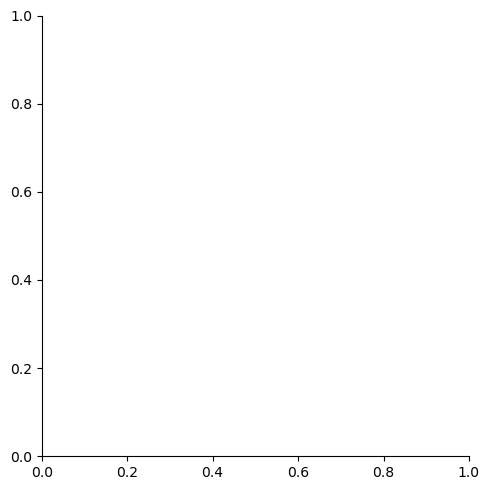

In [47]:
plt.figure(figsize=(10, 6))
sns.lmplot(
    x='Tested - Untested IT Distractor Similarity',
    y='Accuracy',
    x_bins = 5,
    order = 2,
    ci = 68,
    palette = palette[::-1],  # Reverse the color order
    data=df
)


In [ ]:
plt.figure(figsize=(10, 6))
sns.lmplot(
    x='Tested - Untested IT Distractor Similarity',
    y='Accuracy',
    hue = 'Tested Item',
    x_bins = 5,
    order = 2,
    ci = 68,
    palette = palette[::-1],  # Reverse the color order
    data=df
)

In [ ]:
plt.figure(figsize=(10, 6))
sns.lmplot(
    x='Tested - Untested IT Distractor Similarity',
    y='Accuracy',
    hue = 'Retrocue Reliability',
    x_bins = 5,
    order = 2,
    ci = 68,
    palette = palette[::-1],  # Reverse the color order
    data=df
)

In [ ]:
plt.figure(figsize=(10, 6))
sns.lmplot(
    x='Tested - Untested IT Distractor Similarity',
    y='Accuracy',
    row = 'Retrocue Reliability',
    hue = 'Tested Item',
    x_bins = 5,
    order = 2,
    ci = 68,
    palette = palette[::-1],  # Reverse the color order
    data=df
)


In [ ]:

plt.figure(figsize=(10, 6))
sns.lmplot(
    x='Prioritized - Deprioritized IT Distractor Similarity',
    y='Accuracy',
    row = 'Retrocue Reliability',
    hue = 'Tested Item',
    x_bins = 5,
    order = 2,
    ci = 68,
    palette = palette[::-1],  # Reverse the color order
    data=df
)


In [ ]:

plt.figure(figsize=(10, 6))
sns.lmplot(
    x='Prioritized - Deprioritized V2 Distractor Similarity',
    y='Accuracy',
    row = 'Retrocue Reliability',
    hue = 'Tested Item',
    x_bins = 5,
    order = 2,
    ci = 68,
    palette = palette[::-1],  # Reverse the color order
    data=df
)


In [ ]:
plt.figure(figsize=(10, 6))
sns.lmplot(
    x='Tested - Untested V2 Distractor Similarity',
    y='Accuracy',
    x_bins = 5,
    order = 2,
    ci = 68,
    palette = palette[::-1],  # Reverse the color order
    data=df
)

In [ ]:
plt.figure(figsize=(10, 6))
sns.lmplot(
    x='Tested - Untested V2 Distractor Similarity',
    y='Accuracy',
    hue = 'Tested Item',
    x_bins = 5,
    order = 2,
    ci = 68,
    palette = palette[::-1],  # Reverse the color order
    data=df
)

In [ ]:
plt.figure(figsize=(10, 6))
sns.lmplot(
    x='Tested - Untested V2 Distractor Similarity',
    y='Accuracy',
    hue = 'Retrocue Reliability',
    x_bins = 5,
    order = 2,
    ci = 68,
    palette = palette[::-1],  # Reverse the color order
    data=df
)

In [ ]:
plt.figure(figsize=(10, 6))
sns.lmplot(
    x='Tested - Untested V2 Distractor Similarity',
    y='Accuracy',
    row = 'Retrocue Reliability',
    hue = 'Tested Item',
    x_bins = 5,
    order = 2,
    ci = 68,
    palette = palette[::-1],  # Reverse the color order
    data=df
)

In [ ]:
v2 = df.copy()
it = df.copy()
it['similarity'] = df['it_sim_dis_diff_test_z']
v2['similarity'] = df['v2_sim_dis_diff_test_z']
it['model'] = 'it'
v2['model'] = 'v2'
df_fig = pd.concat([it,
                   v2])
df_fig = df_fig[df_fig['Tested Item']  == 'prioritized']
sns.lmplot(
    x='similarity',
    y='Accuracy',
    col = 'model',
   x_bins = 6,
    order = 2,
    ci = 68,
    x_ci = 68,
    data=df_fig
)

In [ ]:
v2 = df.copy()
it = df.copy()
it['similarity'] = df['it_sim_dis_diff_test_z']
v2['similarity'] = df['v2_sim_dis_diff_test_z']
it['model'] = 'it'
v2['model'] = 'v2'
df_fig = pd.concat([it,
                   v2])
df_fig = df_fig[df_fig['Tested Item']  == 'prioritized']
sns.lmplot(
    x='similarity',
    y='Accuracy',
    col = 'model',
   x_bins = 5,
    order = 2,
    ci = 68,
    x_ci = 68,
    data=df_fig
)

In [ ]:
df['it_sim_dis_diff_test_z'] = scaler.fit_transform(df[['it_sim_dis_diff_test']])
plt.figure(figsize=(10, 6))
sns.lmplot(
    x='it_sim_dis_diff_test_z',
    y='Accuracy',
   x_bins = 5,
    order = 2,
    ci = 68,
    hue = 'Tested Item',
    x_ci = 68,
    data=df
)
g.set(ylim=(0.65, 0.85))


In [ ]:
plt.figure(figsize=(10, 6))
sns.lmplot(
    x='it_sim_dis_test',
    y='Accuracy',
   x_bins = 5,
    order = 2,
    ci = 68,
    hue = 'Tested Item',
    x_ci = 68,
    data=df
)
g.set(ylim=(0.65, 0.85))

In [ ]:
plt.figure(figsize=(10, 6))
sns.lmplot(
    x='v2_sim_dis_test',
    y='Accuracy',
   x_bins = 5,
    order = 2,
    ci = 68,
    hue = 'Tested Item',
    x_ci = 68,
    data=df
)
g.set(ylim=(0.65, 0.85))

In [ ]:
plt.figure(figsize=(10, 6))
sns.lmplot(
    x='v2_sim_dis_test_z',
    y='Accuracy',
   x_bins = 5,
    order = 2,
    ci = 68,
    hue = 'Tested Item',
    x_ci = 68,
    data=df
)
g.set(ylim=(0.65, 0.85))

In [ ]:
v2 = df.copy()
it = df.copy()
it['similarity'] = df['it_sim_dis_test_z']
v2['similarity'] = df['v2_sim_dis_test_z']
it['model'] = 'it'
v2['model'] = 'v2'
df_fig = pd.concat([it,
                   v2])
df_fig = df_fig[df_fig['Tested Item']  == 'prioritized']
sns.lmplot(
    x='similarity',
    y='Accuracy',
    col = 'model',
   x_bins = 5,
    order = 2,
    ci = 68,
    x_ci = 68,
    data=df_fig
)

In [ ]:



g = sns.catplot(
            x = 'Tested - Untested V2 Distractor Similarity Ranges',
            y = 'Accuracy',
            ci = 68,
            hue = 'Retrocue Reliability',
            # col = 'Retrocue Reliability',
            aspect = 1.3,
#             dodge = 0.5,
            kind = 'point',
            
            palette = palette,  # Reverse the color order
            data = df)
g.set(ylim=(0.65, 0.85))
plt.xticks(rotation=45)


plt.ylabel('Accuracy')



In [ ]:


g = sns.catplot(
    x='Tested - Untested V2 Distractor Similarity Ranges',
    y='Accuracy',
    ci=68,
    hue='Tested Item',
    row='Retrocue Reliability',  # Use 'row' instead of 'col'
    aspect=1.3,
    row_order = ['low', 'high'],
    dodge=0.5,
    kind='point',
    palette=palette[::-1],  # Use the reversed color order
    data=df
)
g.set(ylim=(0.55, 0.9))

# Rotate the x-axis labels
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

g.set_axis_labels("Tested - Untested V2 Distractor Similarity Ranges", "Accuracy")
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.pointplot(
    x='V2_diff_binned_test',
    y='Accuracy',
    hue = 'it_prefers_test',
    errorbar=('ci', 68),  # Updated error bar parameter
    dodge=0.5,
    palette=palette,  # Use the single-color palette
    data=df
)
plt.ylim(0.65, 0.8)
plt.ylabel('Accuracy')
plt.xlabel('Tested - Untested V2 Distractor Similarity')
plt.title('Accuracy by V2 Distractor Similarity')
plt.show()

In [ ]:
g = sns.catplot(
            x = 'Tested - Untested V2 Distractor Similarity Ranges',
            y = 'Accuracy',
            ci = 68,
            row = 'it_prefers_test',
            hue = 'Tested Item',
            # col = 'Retrocue Reliability',
            aspect = 1.3,
            dodge = 0.5,
            kind = 'point',
            
            palette = palette[::-1],  # Reverse the color order
            data = df)
g.set(ylim=(0.55, 0.85))
plt.xticks(rotation=45)

plt.ylabel('Accuracy')

In [ ]:
g = sns.catplot(x='Tested - Untested V2 Distractor Similarity Ranges', y='analysis_rt', 
#                 hue='Tested Item', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            # order=['Least Similar', ' ', ' ', ' ', 'Most Similar'],  # Specify the order of the categories
            palette = single_color_palette  # Reverse the color order
)
g.set(ylim=(1.5, 1.65))

plt.xlabel('Tested - Untested V2 Distractor Similarity Ranges')
plt.ylabel('Processed Mouse Time (RT)')
plt.title('Processed Mouse Time (RT) vs Tested - Untested V2 Distractor Similarity Ranges')
plt.tight_layout()
plt.show()

In [ ]:
g = sns.catplot(x='Tested - Untested V2 Distractor Similarity Ranges', y='analysis_rt', 
                hue='Tested Item', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            palette = palette[::-1]  # Reverse the color order
)
g.set(ylim=(1.4, 1.8))

plt.xlabel('Tested - Untested V2 Distractor Similarity Ranges')
plt.ylabel('Processed Mouse Time (RT)')
plt.title('Processed Mouse Time (RT) vs Tested - Untested V2 Distractor Similarity Ranges')
plt.tight_layout()
plt.show()

In [ ]:
g = sns.catplot(x='Tested - Untested V2 Distractor Similarity Ranges', y='analysis_rt', 
                hue='Retrocue Reliability', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            palette = palette  # Reverse the color order
)
g.set(ylim=(1.45, 1.7))

plt.xlabel('Tested - Untested V2 Distractor Similarity Ranges')
plt.ylabel('Processed Mouse Time (RT)')
plt.title('Processed Mouse Time (RT) vs Tested - Untested V2 Distractor Similarity Ranges')
plt.tight_layout()
plt.show()

In [ ]:
g = sns.catplot(
    x='Tested - Untested V2 Distractor Similarity Ranges',
    y='analysis_rt',
    row='Retrocue Reliability',
    hue='Tested Item',  # Use 'row' instead of 'col'
    kind='point',
    row_order = ['low', 'high'],
    data=df_correct,
    dodge=True,
    height=6,
    aspect=1.5,
    palette=palette[::-1]  # Use the reversed color order
)
g.set(ylim=(1.3, 1.9))

# Rotate the x-axis labels
for ax in g.axes.flat:
    ax.set_xlabel('Tested - Untested V2 Distractor Similarity Ranges')
    for label in ax.get_xticklabels():
        label.set_rotation(45)

# Set the y-axis label for all plots
g.set_axis_labels('Tested - Untested V2 Distractor Similarity Ranges', 'Processed Mouse Time (RT)')

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.pointplot(
    x='V2_diff_binned_test',
    y='Accuracy',
    hue = 'it_prefers_test',
    errorbar=('ci', 68),  # Updated error bar parameter
#     dodge=0.5,
    palette=palette[::-1],  # Use the single-color palette
    data=df
)
plt.ylim(0.65, 0.8)
plt.ylabel('Accuracy')
plt.xlabel('Tested - Untested V2 Distractor Similarity')
plt.title('Accuracy by V2 Distractor Similarity')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.pointplot(
    x='IT_diff_binned_test',
    y='Accuracy',
    hue = 'v2_prefers_test',
    errorbar=('ci', 68),  # Updated error bar parameter
#     dodge=0.5,
    palette=palette[::-1],  # Use the single-color palette
    data=df
)
plt.ylim(0.65, 0.8)
plt.ylabel('Accuracy')
plt.xlabel('Tested - Untested IT Distractor Similarity')
plt.title('Accuracy by IT Distractor Similarity')
plt.show()

In [ ]:
g = sns.catplot(
            x = 'Tested - Untested IT Distractor Similarity Ranges',
            y = 'Accuracy',
            ci = 68,
#             row = 'v2_prefers_test',
#             hue = 'Tested Item',
            # col = 'Retrocue Reliability',
            aspect = 1.3,
            dodge = 0.5,
            kind = 'point',
            
#             palette = palette[::-1],  # Reverse the color order
            data = df)
g.set(ylim=(0.55, 0.85))
plt.xticks(rotation=45)

plt.ylabel('Accuracy')

In [ ]:
plt.figure(figsize=(10, 6))
sns.pointplot(
    x='IT_diff_binned_test',
    y='Accuracy',
    errorbar=('ci', 68),  # Updated error bar parameter
    dodge=0.5,
    palette=single_color_palette,  # Use the single-color palette
    data=df
)
plt.ylim(0.65, 0.8)
plt.ylabel('Accuracy')
plt.xlabel('Tested - Untested IT Distractor Similarity')
plt.title('Accuracy by IT Distractor Similarity')
plt.show()

In [ ]:
g = sns.catplot(
            x = 'Tested - Untested IT Distractor Similarity Ranges',
            y = 'Accuracy',
            ci = 68,
#             row = 'v2_prefers',
            hue = 'Tested Item',
            # col = 'Retrocue Reliability',
            aspect = 1.3,
#             dodge = 0.5,
            kind = 'point',
            
            palette = palette[::-1],  # Reverse the color order
            data = df)
g.set(ylim=(0.55, 0.85))
plt.xticks(rotation=45)

plt.ylabel('Accuracy')

In [ ]:
g = sns.catplot(
            x = 'Tested - Untested IT Distractor Similarity Ranges',
            y = 'Accuracy',
            ci = 68,
            hue = 'Retrocue Reliability',
            # col = 'Retrocue Reliability',
            aspect = 1.3,
#             dodge = 0.5,
            kind = 'point',
            
            palette = palette,  # Reverse the color order
            data = df)
g.set(ylim=(0.65, 0.85))
plt.xticks(rotation=45)

plt.ylabel('Accuracy')

In [ ]:


g = sns.catplot(
    x='Tested - Untested IT Distractor Similarity Ranges',
    y='Accuracy',
    ci=68,
    hue='Tested Item',
    row='Retrocue Reliability',  # Use 'row' instead of 'col'
    aspect=1.3,
    row_order = ['low', 'high'],
#     dodge=0.5,
    kind='point',
    palette=palette[::-1],  # Use the reversed color order
    data=df
)
g.set(ylim=(0.55, 0.9))

# Rotate the x-axis labels
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

g.set_axis_labels("Tested - Untested IT Distractor Similarity Ranges", "Accuracy")
plt.tight_layout()
plt.show()

In [ ]:
g = sns.catplot(x='Tested - Untested IT Distractor Similarity Ranges', y='analysis_rt', 
#                 hue='Tested Item', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            # order=['Least Similar', ' ', ' ', ' ', 'Most Similar'],  # Specify the order of the categories
            palette = single_color_palette  # Reverse the color order
)
g.set(ylim=(1.5, 1.7))

plt.xlabel('Tested - Untested IT Distractor Similarity Ranges')
plt.ylabel('Processed Mouse Time (RT)')
plt.title('Processed Mouse Time (RT) vs Tested - Untested IT Distractor Similarity Ranges')
plt.tight_layout()
plt.show()

In [ ]:
g = sns.catplot(x='Tested - Untested IT Distractor Similarity Ranges', y='analysis_rt', 
                hue='Tested Item', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            palette = palette[::-1]  # Reverse the color order
)
g.set(ylim=(1.4, 1.8))

plt.xlabel('Tested - Untested IT Distractor Similarity Ranges')
plt.ylabel('Processed Mouse Time (RT)')
plt.title('Processed Mouse Time (RT) vs Tested - Untested IT Distractor Similarity Ranges')
plt.tight_layout()
plt.show()

In [ ]:
g = sns.catplot(x='Tested - Untested IT Distractor Similarity Ranges', y='analysis_rt', 
                hue='Retrocue Reliability', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            palette = palette  # Reverse the color order
)
g.set(ylim=(1.45, 1.7))

plt.xlabel('Tested - Untested IT Distractor Similarity Ranges')
plt.ylabel('Processed Mouse Time (RT)')
plt.title('Processed Mouse Time (RT) vs Tested - Untested IT Distractor Similarity Ranges')
plt.tight_layout()
plt.show()

In [ ]:
g = sns.catplot(
    x='Tested - Untested IT Distractor Similarity Ranges',
    y='analysis_rt',
    row='Retrocue Reliability',
    hue='Tested Item',  # Use 'row' instead of 'col'
    kind='point',
    row_order = ['low', 'high'],
    data=df_correct,
    dodge=True,
    height=6,
    aspect=1.5,
    palette=palette[::-1] # Use the reversed color order
)
g.set(ylim=(1.3, 1.9))

# Rotate the x-axis labels
for ax in g.axes.flat:
    ax.set_xlabel('Tested - Untested IT Distractor Similarity Ranges')
    for label in ax.get_xticklabels():
        label.set_rotation(45)

# Set the y-axis label for all plots
g.set_axis_labels('Tested - Untested IT Distractor Similarity Ranges', 'Processed Mouse Time (RT)')

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.pointplot(
    x='V2_diff_binned_test_sq',
    y='Accuracy',
    errorbar=('ci', 68),  # Updated error bar parameter
    dodge=0.5,
    palette=single_color_palette,  # Use the single-color palette
    data=df
)
plt.ylim(0.7, 0.85)
plt.ylabel('Accuracy')
plt.xlabel('Tested - Untested V2 Distractor Similarity Squared')
plt.title('Accuracy by V2 Distractor Similarity Squared')
plt.show()




In [ ]:

g = sns.catplot(
            x = 'Tested - Untested V2 Distractor Similarity Squared Ranges',
            y = 'Accuracy',
            ci = 68,
            hue = 'Tested Item',
            # col = 'Retrocue Reliability',
            aspect = 1.3,
            dodge = 0.5,
            kind = 'point',
            
            palette = sns.color_palette("husl", n_colors=2),  # Reverse the color order
            data = df)
g.set(ylim=(0.55, 0.85))
plt.xticks(rotation=45)

plt.ylabel('Accuracy')



In [ ]:

g = sns.catplot(
            x = 'Tested - Untested V2 Distractor Similarity Squared Ranges',
            y = 'Accuracy',
            ci = 68,
            hue = 'Retrocue Reliability',
            # col = 'Retrocue Reliability',
            aspect = 1.3,
            dodge = 0.5,
            kind = 'point',
            
            palette = palette,  # Reverse the color order
            data = df)
g.set(ylim=(0.65, 0.85))
plt.xticks(rotation=45)

plt.ylabel('Accuracy')


In [ ]:


g = sns.catplot(
    x='Tested - Untested V2 Distractor Similarity Squared Ranges',
    y='Accuracy',
    ci=68,
    hue='Tested Item',
    row='Retrocue Reliability',  # Use 'row' instead of 'col'
    aspect=1.3,
    row_order = ['low', 'high'],
    dodge=0.5,
    kind='point',
    palette=palette[::-1],  # Use the reversed color order
    data=df
)
g.set(ylim=(0.55, 0.9))

# Rotate the x-axis labels
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

g.set_axis_labels("Tested - Untested V2 Distractor Similarity Squared Ranges", "Accuracy")
plt.tight_layout()
plt.show()

In [ ]:
g = sns.catplot(x='Tested - Untested V2 Distractor Similarity Squared Ranges', y='analysis_rt', 
#                 hue='Tested Item', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            # order=['Least Similar', ' ', ' ', ' ', 'Most Similar'],  # Specify the order of the categories
            palette = single_color_palette  # Reverse the color order
)
g.set(ylim=(1.5, 1.65))

plt.xlabel('Tested - Untested V2 Distractor Similarity Squared Ranges')
plt.ylabel('Processed Mouse Time (RT)')
# plt.title('Processed Mouse Time (RT) vs V2 Distractor Similarity\nSquared Ranges')
plt.tight_layout()
plt.show()



In [ ]:
g = sns.catplot(x='Tested - Untested V2 Distractor Similarity Squared Ranges', y='analysis_rt', 
                hue='Tested Item', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            palette = palette[::-1]  # Reverse the color order
)
g.set(ylim=(1.4, 1.9))

plt.xlabel('Tested - Untested V2 Distractor Similarity Squared Ranges')
plt.ylabel('Processed Mouse Time (RT)')
# plt.title('Processed Mouse Time (RT) vs V2 Distractor Similarity\nto Prioritized Item')
plt.tight_layout()
plt.show()



In [ ]:
g = sns.catplot(x='Tested - Untested V2 Distractor Similarity Squared Ranges', y='analysis_rt', 
                hue='Retrocue Reliability', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            palette = palette  # Reverse the color order
)
g.set(ylim=(1.45, 1.7))

plt.xlabel('Tested - Untested V2 Distractor Similarity Squared Ranges')
plt.ylabel('Processed Mouse Time (RT)')
# plt.title('Prioritized - Deprioritized V2 Distractor Similarity Squared Ranges')
plt.tight_layout()
plt.show()



In [ ]:
g = sns.catplot(
    x='Tested - Untested V2 Distractor Similarity Squared Ranges',
    y='analysis_rt',
    row='Retrocue Reliability',
    hue='Tested Item',  # Use 'row' instead of 'col'
    kind='point',
    row_order = ['low', 'high'], 
    data=df_correct,
    dodge=True,
    height=6,
    aspect=1.5,
    palette=palette[::-1]  # Use the reversed color order
)
g.set(ylim=(1.3, 1.9))

# Rotate the x-axis labels
for ax in g.axes.flat:
    ax.set_xlabel('Tested - Untested V2 Distractor Similarity Squared Ranges')
    for label in ax.get_xticklabels():
        label.set_rotation(45)

# Set the y-axis label for all plots
g.set_axis_labels('Tested - Untested V2 Distractor Similarity Squared Ranges', 'Processed Mouse Time (RT)')

plt.tight_layout()
plt.show()



In [ ]:
plt.figure(figsize=(10, 6))
sns.pointplot(
    x='IT_diff_binned_test_sq',
    y='Accuracy',
    errorbar=('ci', 68),  # Updated error bar parameter
    dodge=0.5,
    palette=single_color_palette,  # Use the single-color palette
    data=df
)
plt.ylim(0.7, 0.85)
plt.ylabel('Accuracy')
plt.xlabel('Tested - Untested IT Distractor Similarity Squared')
plt.title('Accuracy by IT Distractor Similarity Squared')
plt.show()


In [ ]:


g = sns.catplot(
            x = 'Tested - Untested IT Distractor Similarity Squared Ranges',
            y = 'Accuracy',
            ci = 68,
            hue = 'Tested Item',
            # col = 'Retrocue Reliability',
            aspect = 1.3,
            dodge = 0.5,
            kind = 'point',
            
            palette = sns.color_palette("husl", n_colors=2),  # Reverse the color order
            data = df)
g.set(ylim=(0.55, 0.85))
plt.xticks(rotation=45)

plt.ylabel('Accuracy')



In [ ]:

g = sns.catplot(
            x = 'Tested - Untested IT Distractor Similarity Squared Ranges',
            y = 'Accuracy',
            ci = 68,
            hue = 'Retrocue Reliability',
            # col = 'Retrocue Reliability',
            aspect = 1.3,
            dodge = 0.5,
            kind = 'point',
            
            palette = palette,  # Reverse the color order
            data = df)
g.set(ylim=(0.65, 0.85))
plt.xticks(rotation=45)

plt.ylabel('Accuracy')



In [ ]:

g = sns.catplot(
    x='Tested - Untested IT Distractor Similarity Squared Ranges',
    y='Accuracy',
    ci=68,
    hue='Tested Item',
    row='Retrocue Reliability',  # Use 'row' instead of 'col'
    aspect=1.3,
    row_order = ['low', 'high'],
    dodge=0.5,
    kind='point',
    palette=palette[::-1],  # Use the reversed color order
    data=df
)
g.set(ylim=(0.55, 0.9))

# Rotate the x-axis labels
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

g.set_axis_labels("Tested - Untested IT Distractor Similarity Squared Ranges", "Accuracy")
plt.tight_layout()
plt.show()

In [ ]:
g = sns.catplot(x='Tested - Untested IT Distractor Similarity Squared Ranges', y='analysis_rt', 
#                 hue='Tested Item', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            # order=['Least Similar', ' ', ' ', ' ', 'Most Similar'],  # Specify the order of the categories
            palette = single_color_palette  # Reverse the color order
)
g.set(ylim=(1.5, 1.65))

plt.xlabel('Tested - Untested IT Distractor Similarity Squared Ranges')
plt.ylabel('Processed Mouse Time (RT)')
# plt.title('Processed Mouse Time (RT) vs V2 Distractor Similarity\nSquared Ranges')
plt.tight_layout()
plt.show()


In [ ]:

g = sns.catplot(x='Tested - Untested IT Distractor Similarity Squared Ranges', y='analysis_rt', 
                hue='Tested Item', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            palette = palette[::-1]  # Reverse the color order
)
g.set(ylim=(1.4, 1.8))

plt.xlabel('Tested - Untested IT Distractor Similarity Squared Ranges')
plt.ylabel('Processed Mouse Time (RT)')
# plt.title('Processed Mouse Time (RT) vs V2 Distractor Similarity\nto Prioritized Item')
plt.tight_layout()
plt.show()



In [ ]:

g = sns.catplot(x='Tested - Untested IT Distractor Similarity Squared Ranges', y='analysis_rt', 
                hue='Retrocue Reliability', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            palette = palette  # Reverse the color order
)
g.set(ylim=(1.45, 1.7))

plt.xlabel('Tested - Untested IT Distractor Similarity Squared Ranges')
plt.ylabel('Processed Mouse Time (RT)')
# plt.title('Prioritized - Deprioritized V2 Distractor Similarity Squared Ranges')
plt.tight_layout()
plt.show()



In [ ]:
g = sns.catplot(
    x='Tested - Untested IT Distractor Similarity Squared Ranges',
    y='analysis_rt',
    row='Retrocue Reliability',
    hue='Tested Item',  # Use 'row' instead of 'col'
    kind='point',
    row_order = ['low', 'high'],
    data=df_correct,
    dodge=True,
    height=6,
    aspect=1.5,
    palette=palette[::-1]  # Use the reversed color order
)
g.set(ylim=(1.3, 1.9))

# Rotate the x-axis labels
for ax in g.axes.flat:
    ax.set_xlabel('Tested - Untested IT Distractor Similarity Squared Ranges')
    for label in ax.get_xticklabels():
        label.set_rotation(45)

# Set the y-axis label for all plots
g.set_axis_labels('Tested - Untested IT Distractor Similarity Squared Ranges', 'Processed Mouse Time (RT)')

plt.tight_layout()
plt.show()


In [ ]:
len(set(df['participant']))

In [ ]:
df['tested_memorability']

In [ ]:
### instead of Prioritized-Deprioritized similarity on x axis, get (both relative and absolute)
# Similarity to Tested item and then split by prioritzed - x axis will be relative to tested/untested instead of prioritized/deprioritized

In [ ]:
sns.scatterplot(
    x='V2 Distractor Similarity to Tested Item',
    y='Accuracy',
    hue='tested_memorability',        # Numeric
    palette='viridis',               # Continuous colormap
    data=df
)

sns.regplot(
    x='V2 Distractor Similarity to Tested Item',
    y='Accuracy',
    order=2,
    ci=68,
    scatter=False,                   # Don't re-draw points
    color='black',
    data=df
)

plt.title("Accuracy vs. Distractor Similarity Colored by Tested Memorability")
plt.show()

In [ ]:
df['tested_memorability_binned'] = pd.qcut(df['tested_memorability'], q=5, 
                                           labels=['Low','Medium-Low','Medium', 'Medium-High','High'])


In [ ]:
sns.lmplot(
    x='V2 Distractor Similarity to Tested Item',
    y='Accuracy',
    hue='tested_memorability_binned',  # Now it's categorical
    x_bins=5,
    order=2,
    ci=68,
    palette='viridis',
    data=df
)
plt.show()

In [ ]:
sns.lmplot(
    x='IT Distractor Similarity to Tested Item',
    y='Accuracy',
    hue='tested_memorability_binned',  # Now it's categorical
    x_bins=5,
    order=2,
    ci=68,
    palette='viridis',
    data=df
)
plt.show()

In [ ]:
sns.lmplot(
    x='Tested - Untested IT Distractor Similarity',
    y='Accuracy',
    hue='tested_memorability_binned',  # Now it's categorical
    x_bins=5,
    order=2,
    ci=68,
    palette='viridis',
    data=df
)
plt.show()

In [ ]:

g = sns.catplot(
    x='Tested - Untested IT Distractor Similarity Ranges',
    y='Accuracy',
    ci=68,
    hue='Tested Item',
    row='tested_memorability_binned',  # Use 'row' instead of 'col'
    aspect=1.3,
#     row_order = ['low', 'high'],
    dodge=0.5,
    kind='point',
    palette=palette[::-1],  # Use the reversed color order
    data=df
)
g.set(ylim=(0.45, 0.9))

# Rotate the x-axis labels
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

g.set_axis_labels("Tested - Untested IT Distractor Similarity Squared Ranges", "Accuracy")
plt.tight_layout()
plt.show()

In [ ]:
g = sns.catplot(
    x='tested_memorability_binned',
    y='Accuracy',
    ci=68,
    hue='Tested Item',
    row='Retrocue Reliability',
    aspect=1.3,
#     row_order = ['low', 'high'],
    dodge=0.5,
    kind='point',
    palette=palette[::-1],  # Use the reversed color order
    data=df
)
g.set(ylim=(0.45, 0.9))


In [ ]:

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(121, projection='3d')
scatter = ax1.scatter(df['V2 Distractor Similarity to Tested Item'],
                     df['tested_memorability'],
                     df['Accuracy'],
                     c=df['tested_memorability'],
                     cmap='viridis',
                     s=50)
ax1.set_xlabel('Distractor Similarity')
ax1.set_ylabel('Memorability')
ax1.set_zlabel('Accuracy')
ax1.set_title('3D Scatter Plot with Memorability Color Gradient')
plt.colorbar(scatter, label='Memorability')

ax2 = fig.add_subplot(122, projection='3d')

x = np.linspace(df['V2 Distractor Similarity to Tested Item'].min(), 
                df['V2 Distractor Similarity to Tested Item'].max(), 20)
y = np.linspace(df['tested_memorability'].min(), 
                df['tested_memorability'].max(), 20)
X, Y = np.meshgrid(x, y)

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

X_train = df[['V2 Distractor Similarity to Tested Item', 'tested_memorability']]
y_train = df['Accuracy']

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train)

model = LinearRegression()
model.fit(X_poly, y_train)

X_pred = np.column_stack((X.ravel(), Y.ravel()))
X_pred_poly = poly.transform(X_pred)
Z = model.predict(X_pred_poly).reshape(X.shape)

surf = ax2.plot_surface(X, Y, Z, cmap='viridis',
                       linewidth=0, antialiased=True)
ax2.set_xlabel('Distractor Similarity')
ax2.set_ylabel('Memorability')
ax2.set_zlabel('Accuracy')
ax2.set_title('3D Surface Plot of Accuracy Prediction')
plt.colorbar(surf, label='Predicted Accuracy')

plt.tight_layout()

import plotly.express as px
import plotly.graph_objects as go

fig_plotly = go.Figure(data=[go.Scatter3d(
    x=df['V2 Distractor Similarity to Tested Item'],
    y=df['tested_memorability'],
    z=df['Accuracy'],
    mode='markers',
    marker=dict(
        size=6,
        color=df['tested_memorability'],
        colorscale='Viridis',
        opacity=0.8
    )
)])

fig_plotly.update_layout(
    title='Interactive 3D Scatter Plot',
    scene=dict(
        xaxis_title='Distractor Similarity',
        yaxis_title='Memorability',
        zaxis_title='Accuracy'
    ),
    width=800,
    height=800
)



In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler

df_scaled = df.copy()
columns_to_scale = ['V2 Distractor Similarity to Tested Item', 'tested_memorability', 'Accuracy']
df_scaled[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=df['V2 Distractor Similarity to Tested Item'],
    y=df['tested_memorability'],
    z=df['Accuracy'],
    mode='markers',
    marker=dict(
        size=4,
        color=df['tested_memorability'],
        colorscale='Viridis',
        opacity=0.8,
        colorbar=dict(
            title='Memorability',
            thickness=20,
            len=0.75,
            x=0.95
        )
    ),
    hovertemplate=
    '<b>Distractor Similarity:</b> %{x:.2f}<br>' +
    '<b>Memorability:</b> %{y:.2f}<br>' +
    '<b>Accuracy:</b> %{z:.2f}<br>' +
    '<extra></extra>'  
))

x_range = np.linspace(df['V2 Distractor Similarity to Tested Item'].min(), 
                     df['V2 Distractor Similarity to Tested Item'].max(), 50)
y_range = np.linspace(df['tested_memorability'].min(), 
                     df['tested_memorability'].max(), 50)
x_mesh, y_mesh = np.meshgrid(x_range, y_range)

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

model = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('linear', LinearRegression())
])

X = df[['V2 Distractor Similarity to Tested Item', 'tested_memorability']]
y = df['Accuracy']
model.fit(X, y)

X_pred = np.vstack([x_mesh.ravel(), y_mesh.ravel()]).T
z_mesh = model.predict(X_pred).reshape(x_mesh.shape)

fig.add_trace(go.Surface(
    x=x_range,
    y=y_range,
    z=z_mesh,
    opacity=0.3,
    colorscale='Viridis',
    showscale=False,
    hoverinfo='skip'
))

fig.update_layout(
    title=dict(
        text='Memory Performance Analysis',
        x=0.5,
        y=0.95,
        font=dict(size=24)
    ),
    scene=dict(
        xaxis_title=dict(
            text='Distractor Similarity',
            font=dict(size=14)
        ),
        yaxis_title=dict(
            text='Memorability',
            font=dict(size=14)
        ),
        zaxis_title=dict(
            text='Accuracy',
            font=dict(size=14)
        ),
        camera=dict(
            up=dict(x=0, y=0, z=1),
            center=dict(x=0, y=0, z=0),
            eye=dict(x=1.5, y=1.5, z=1.5)
        ),
        aspectmode='cube'
    ),
    template='plotly_white',
    showlegend=False,
    width=900,
    height=700,
    margin=dict(l=0, r=0, t=30, b=0)
)

fig.update_layout(
    updatemenus=[
        dict(
            type='buttons',
            showactive=False,
            buttons=[
                dict(
                    label='Top View',
                    method='relayout',
                    args=['scene.camera', dict(
                        up=dict(x=0, y=0, z=1),
                        center=dict(x=0, y=0, z=0),
                        eye=dict(x=0, y=0, z=2)
                    )]
                ),
                dict(
                    label='Side View',
                    method='relayout',
                    args=['scene.camera', dict(
                        up=dict(x=0, y=0, z=1),
                        center=dict(x=0, y=0, z=0),
                        eye=dict(x=2, y=0, z=0)
                    )]
                ),
                dict(
                    label='Isometric',
                    method='relayout',
                    args=['scene.camera', dict(
                        up=dict(x=0, y=0, z=1),
                        center=dict(x=0, y=0, z=0),
                        eye=dict(x=1.5, y=1.5, z=1.5)
                    )]
                )
            ],
            x=0.1,
            y=1.1,
            xanchor='left',
            yanchor='top'
        )
    ]
)

fig.show()